<center><b><font size=6>Supervised learning – classification<b><center>

This notebook implements the supervised learning component of the SSH Shell Attack session project. The goal is to classify attack session tactics based on the provided dataset.

0. **Install Dependencies**
1. **Data Splitting**
2. **Baseline Model Implementation**
3. **Hyperparameter Tuning**
4. **Result Analysis**  
5. **Feature Experimentation**

<center><b><font size=5>Install Dependencies<b><center>

In [12]:
!python ../scripts/install_dependencies.py section2

Installing common dependencies...
Installing packages for common: pyarrow, pandas
Installing dependencies for section: section2...
Installing packages for section2: scikit-learn


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


<center><b><font size=5>Data Splitting<b><center>

Split the dataset into training and testing sets.

"Perform a split to segment the dataset into training and test dataset.
If you want to standardize your dataset, fit the scaler on training set and transforming both training
and test. Notice that the sklearn implementation of tf-idf already performs the standardization."

**Steps:**

- Load the dataset from the given `.parquet` file.
- Explore basic statistics and check for missing data.
- Visualize the distribution of intents in the dataset.

### Load the dataset

- text
- text

In [14]:
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
SSH_Attacks

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,"[cat, proc, cp, grep, name, echo, passwd, bash...",2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,"[cat, proc, cp, grep, name, echo, passwd, bash...",2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,"[cat, proc, cp, grep, name, echo, ss, passwd, ...",2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,"[cat, proc, cp, grep, name, echo, passwd, bash...",2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


### Check for ... / Make some actions

- text
- text

In [15]:
# Display the first few rows of the dataset
print("Dataset Head:")
print(SSH_Attacks.head())  # Useful to quickly verify the structure of the dataset

# Display a random sample of 5 rows to get an idea of the dataset's variability
print("\nRandom Sample:")
print(SSH_Attacks.sample(5))

# Provide an overview of the dataset, including column data types and memory usage
print("Dataset Overview:")
print(SSH_Attacks.info(memory_usage='deep'))  # Using 'deep' to handle potential memory usage issues

# Display summary statistics for selected columns
print("\nSummary Statistics (Selected Columns):")
print(SSH_Attacks[['session_id', 'first_timestamp']].describe(include='all'))  # Focus on simpler columns

# Create a sample of 1000 rows from the dataset for faster analysis
SSH_Attacks_sample = SSH_Attacks.sample(1000, random_state=42)  # Ensures reproducibility with random_state

# Measure execution time for the dataset overview
start_time = time.time()
print(SSH_Attacks.info(memory_usage='deep'))  # Repeat to observe any differences or delays
print("Execution Time: {:.2f} seconds".format(time.time() - start_time))  # Outputs time taken for the operation

Dataset Head:
   session_id                                       full_session  \
0           0  [enable, system, sh, sh, cat, proc, mounts, bi...   
1           1  [enable, system, sh, sh, cat, proc, mounts, bi...   
2           2  [enable, system, sh, sh, cat, proc, mounts, bi...   
3           3  [enable, system, sh, sh, cat, proc, mounts, bi...   
4           4  [enable, system, sh, sh, cat, proc, mounts, bi...   

                   first_timestamp               Set_Fingerprint  
0 2019-06-04 09:45:11.151186+00:00  [Defense Evasion, Discovery]  
1 2019-06-04 09:45:50.396610+00:00  [Defense Evasion, Discovery]  
2 2019-06-04 09:54:41.863315+00:00  [Defense Evasion, Discovery]  
3 2019-06-04 10:22:14.623875+00:00  [Defense Evasion, Discovery]  
4 2019-06-04 10:37:19.725874+00:00  [Defense Evasion, Discovery]  

Random Sample:
        session_id                                       full_session  \
221873      221884  [cat, proc, cp, grep, name, echo, ss, passwd, ...   
191269      1

c:\users\x\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  from ipykernel import kernelapp as app


### Split the dataset

- text
- text

In [16]:
# Split the data into features (X) and labels (y)
X = SSH_Attacks['full_session']  # Text data
y = SSH_Attacks['Set_Fingerprint']  # Multi-label target

# Split into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Convert to strings to ensure compatibility with TfidfVectorizer
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Vectorize the text data using TF-IDF (standardization is included in TF-IDF by default)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert multi-label data into binary format
y_train_list = y_train.apply(lambda x: set(x))
y_test_list = y_test.apply(lambda x: set(x))

mlb = MultiLabelBinarizer()
y_train_binary = pd.DataFrame(mlb.fit_transform(y_train_list), columns=mlb.classes_, index=y_train.index)
y_test_binary = pd.DataFrame(mlb.transform(y_test_list), columns=mlb.classes_, index=y_test.index)

# Print basic info about the processed data
print("\nProcessed Training set size:", len(X_train))
print("Processed Testing set size:", len(X_test))
print("Classes:", mlb.classes_)



Processed Training set size: 163124
Processed Testing set size: 69911
Classes: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']


<center><b><font size=5>Baseline Model Implementation<b><center>

Train at least two ML models and evaluate their performance.

"Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?"

**Steps:**

- Train different ML models (e.g., Logistic Regression and Random Forest).
- Logistic Regression - Training and Evaluation.
- Random Forest - Training and Evaluation.
- Support Vector Machine (SVM) - Training and Evaluation.
- Compare performance and check for overfitting/underfitting.

### Chose models and train

- text
- text

In [17]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42)  # Linear kernel for SVM
}


### Logistic Regression

- text
- text

Training for label: Defense Evasion
Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64277
           1       0.98      0.96      0.97      5634

    accuracy                           1.00     69911
   macro avg       0.99      0.98      0.99     69911
weighted avg       1.00      1.00      1.00     69911



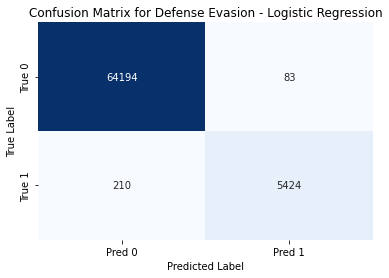

Training for label: Discovery
Classification Report for Discovery:

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       252
           1       1.00      1.00      1.00     69659

    accuracy                           1.00     69911
   macro avg       0.96      0.94      0.95     69911
weighted avg       1.00      1.00      1.00     69911



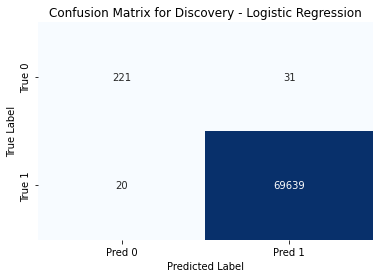

Training for label: Execution
Classification Report for Execution:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     42194
           1       1.00      0.99      0.99     27717

    accuracy                           0.99     69911
   macro avg       1.00      0.99      0.99     69911
weighted avg       0.99      0.99      0.99     69911



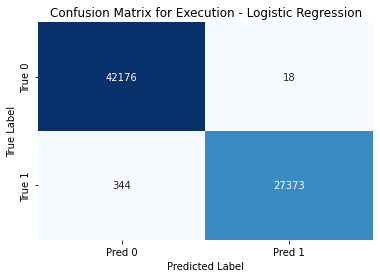

Training for label: Harmless
Classification Report for Harmless:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     69241
           1       0.92      0.09      0.17       670

    accuracy                           0.99     69911
   macro avg       0.96      0.55      0.58     69911
weighted avg       0.99      0.99      0.99     69911



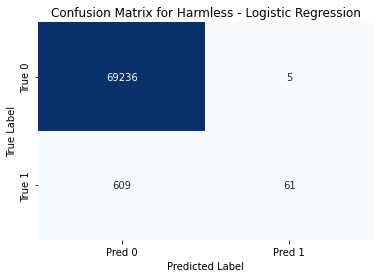

Training for label: Impact
Classification Report for Impact:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69909
           1       0.00      0.00      0.00         2

    accuracy                           1.00     69911
   macro avg       0.50      0.50      0.50     69911
weighted avg       1.00      1.00      1.00     69911



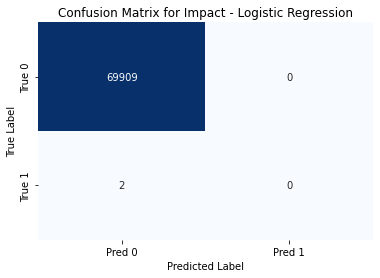

Training for label: Other
Classification Report for Other:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69808
           1       1.00      0.90      0.95       103

    accuracy                           1.00     69911
   macro avg       1.00      0.95      0.97     69911
weighted avg       1.00      1.00      1.00     69911



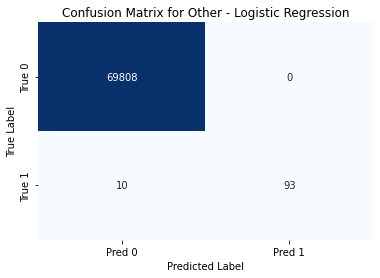

Training for label: Persistence
Classification Report for Persistence:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      6480
           1       1.00      1.00      1.00     63431

    accuracy                           1.00     69911
   macro avg       1.00      0.99      0.99     69911
weighted avg       1.00      1.00      1.00     69911



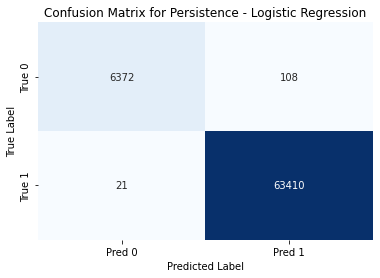

In [19]:
# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Create an empty DataFrame to store predictions for multilabel compatibility
y_pred_log_reg = pd.DataFrame(index=y_test_binary.index, columns=y_test_binary.columns)

# Train and evaluate for each label
for label in y_train_binary.columns:
    print(f"Training for label: {label}")
    
    # Train the model
    log_reg_model.fit(X_train_tfidf, y_train_binary[label])
    
    # Predict and store the results in the corresponding column
    y_pred_log_reg[label] = log_reg_model.predict(X_test_tfidf)
    
    # Evaluate performance for the specific label
    print(f"Classification Report for {label}:\n")
    print(classification_report(
        y_test_binary[label], 
        y_pred_log_reg[label], 
        zero_division=0          # To avoid the warning for precision and F-score.
    ))

    # Confusion Matrix for Logistic Regression
    cm_log_reg = confusion_matrix(y_test_binary[label], y_pred_log_reg[label])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix for {label} - Logistic Regression")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    
    
""" --- PER FARE UN'UNICA STAMPA E NON LE SINGOLE COLONNE ---

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the Logistic Regression model
log_reg_model.fit(X_train_tfidf, y_train_binary['Persistence'])  # Example for 'Persistence'

# Make predictions
y_pred_log_reg = log_reg_model.predict(X_test_tfidf)

# Evaluation for Logistic Regression
print("Classification Report for Logistic Regression:")
print(classification_report(y_test_binary['Persistence'], y_pred_log_reg, zero_division=0))

# Confusion Matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_test_binary['Persistence'], y_pred_log_reg)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix for Logistic Regression")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

"""


### Random Forest

- text
- text

Training for label: Defense Evasion
Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64277
           1       0.99      0.97      0.98      5634

    accuracy                           1.00     69911
   macro avg       1.00      0.98      0.99     69911
weighted avg       1.00      1.00      1.00     69911



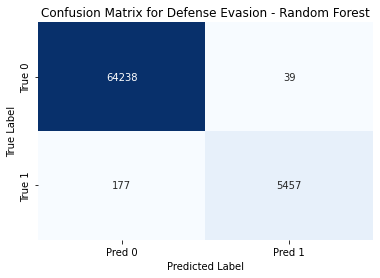

Training for label: Discovery
Classification Report for Discovery:

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       252
           1       1.00      1.00      1.00     69659

    accuracy                           1.00     69911
   macro avg       0.97      0.97      0.97     69911
weighted avg       1.00      1.00      1.00     69911



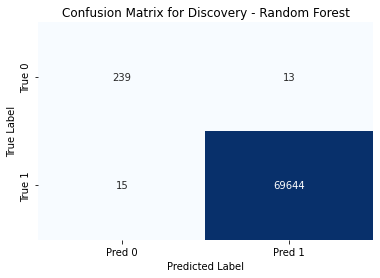

Training for label: Execution
Classification Report for Execution:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     42194
           1       1.00      0.99      0.99     27717

    accuracy                           1.00     69911
   macro avg       1.00      0.99      0.99     69911
weighted avg       1.00      1.00      1.00     69911



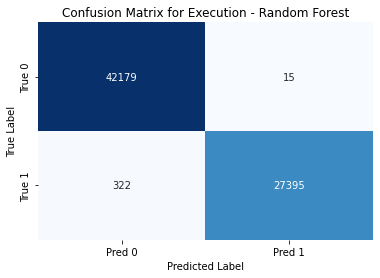

Training for label: Harmless
Classification Report for Harmless:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     69241
           1       0.92      0.16      0.27       670

    accuracy                           0.99     69911
   macro avg       0.95      0.58      0.63     69911
weighted avg       0.99      0.99      0.99     69911



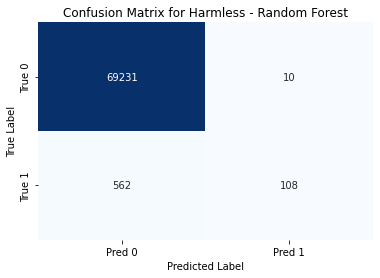

Training for label: Impact
Classification Report for Impact:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69909
           1       0.00      0.00      0.00         2

    accuracy                           1.00     69911
   macro avg       0.50      0.50      0.50     69911
weighted avg       1.00      1.00      1.00     69911



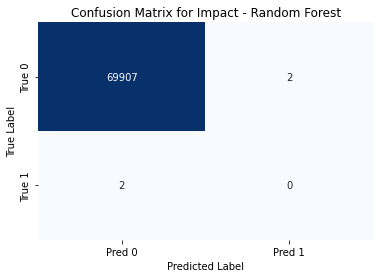

Training for label: Other
Classification Report for Other:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69808
           1       1.00      0.95      0.98       103

    accuracy                           1.00     69911
   macro avg       1.00      0.98      0.99     69911
weighted avg       1.00      1.00      1.00     69911



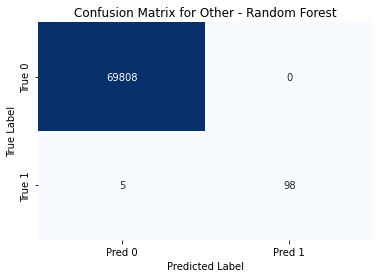

Training for label: Persistence
Classification Report for Persistence:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6480
           1       1.00      1.00      1.00     63431

    accuracy                           1.00     69911
   macro avg       1.00      1.00      1.00     69911
weighted avg       1.00      1.00      1.00     69911



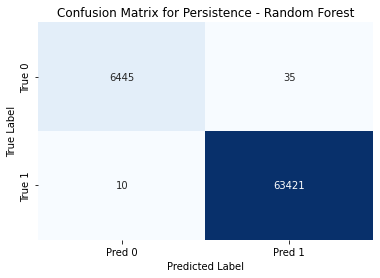

In [20]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create an empty DataFrame to store predictions for multilabel compatibility
y_pred_rf = pd.DataFrame(index=y_test_binary.index, columns=y_test_binary.columns)

# Train and evaluate for each label
for label in y_train_binary.columns:
    print(f"Training for label: {label}")
    
    # Train the model
    rf_model.fit(X_train_tfidf, y_train_binary[label])
    
    # Predict and store the results in the corresponding column
    y_pred_rf[label] = rf_model.predict(X_test_tfidf)
    
    # Evaluate performance for the specific label
    print(f"Classification Report for {label}:\n")
    print(classification_report(
        y_test_binary[label], 
        y_pred_rf[label], 
        zero_division=0
    ))

    # Confusion Matrix for Random Forest
    cm_rf = confusion_matrix(y_test_binary[label], y_pred_rf[label])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix for {label} - Random Forest")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Support Vector Machine (SVM)

- text
- text

In [ ]:
# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Create an empty DataFrame to store predictions for multilabel compatibility
y_pred_svm = pd.DataFrame(index=y_test_binary.index, columns=y_test_binary.columns)

# Train and evaluate for each label
for label in y_train_binary.columns:
    print(f"Training for label: {label}")
    
    # Train the model
    svm_model.fit(X_train_tfidf, y_train_binary[label])
    
    # Predict and store the results in the corresponding column
    y_pred_svm[label] = svm_model.predict(X_test_tfidf)
    
    # Evaluate performance for the specific label
    print(f"Classification Report for {label}:\n")
    print(classification_report(
        y_test_binary[label], 
        y_pred_svm[label], 
        zero_division=0
    ))

    # Confusion Matrix for SVM
    cm_svm = confusion_matrix(y_test_binary[label], y_pred_svm[label])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix for {label} - SVM")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Training for label: Defense Evasion


### Compare performance

- text
- text

<center><b><font size=5>Hyperparameter Tuning<b><center>

Fine-tune the hyperparameters of the ML models using cross-validation.

"Tune the hyper-parameters of the models through cross-validation. How do performance vary?"

**Steps:**

TO BE CHECKED

- Use GridSearchCV or RandomizedSearchCV to tune hyperparameters.
- Evaluate the performance of the tuned models.
- Compare the results with baseline performance.

### text

- text
- text

### text

- text
- text

### text

- text
- text

<center><b><font size=5>Result Analysis<b><center>

Analyze and summarize the results for each intent.

"Comments on the results for each on the intents."

**Steps:**

- Compare confusion matrices and classification reports.
- Highlight trends and insights for each intent.
- Summarize findings and discuss implications.

### text

- text
- text

### text

- text
- text

### text

- text
- text

<center><b><font size=5>Feature Experimentation<b><center>

Explore the impact of different features on model performance.

"Explore the possible features: try combining features differently, e.g., does tf-idf improve or worsen
performance? Think about the problem and summarize the ways you have tried (even those that
did not work)."

**Steps:**

- Experiment with feature combinations (e.g., adding temporal features).
- Observe performance changes with each combination.
- Document successful and unsuccessful experiments.

### text

- text
- text

### text

- text
- text

### text

- text
- text